# Guide Notebook

This notebook is designed to provide a guide for the replication project with sample of the data structure, key functionalities of our code, challenges we faced and the result of replication.


In [ ]:
import config
from pathlib import Path
OUTPUT_DIR = Path(config.OUTPUT_DIR)

In [15]:
import numpy as np
from matplotlib import pyplot as plt
import plot_cds_returns
from plot_cds_returns import plot_cds_returns_mean
from plot_cds_returns import plot_cds_returns_median
from plot_cds_returns import plot_cds_returns_weighted


## Data Fetch:

There are two key data features we fetch. 

1) CDS Rates: Source: Markit on WRDS

2) Risk free rates: Fred website and FED website - 

        3-Month Treasury Constant Maturity Rate: https://fred.stlouisfed.org/series/DGS3MO
        6-Month Treasury Constant Maturity Rate: https://fred.stlouisfed.org/series/DGS6MO 
        Swap Rates: https://www.federalreserve.gov/data/yield-curve-tables/feds200628_

The data fetch process is automated. The CDS rates are fetched via WRDS queries to the SAS database server that hosts Markit tables. 

The risk free rates are fetched from the websites using pandas webreader. 


### CDS Data

The below snippet shows how we fetch the cds data from Markit. 

This fetched data has close to 6000 tickers. We fetch the parspread for each day available from 2001 to 2024. The paper uses data until 2016, however we extend to the whole period available. 

<img src="../assets/snip_1.png" alt="Image Description" width="500">

#### Processing Steps:

The paper states 20 CDS portoflios are created, however it does not offer details on the construction of the 20 portfolios using the 6000 tickers available. 

We propose the following process based on our research of the CDS returns calculation and He Kelly Manela's paper. This methodology is in consultation with the Professor Jeremey. 

1) Since the returns is calculated on a monthly basis, we resample the CDS data to monthly 

2) We propose to construct the 20 portfolios by splitting the set of CDS monthly rates for the 6000 tickets into 20 quantiles. This ensures a monthly rebalancing into quantiles. 

3) Once we have all 6000 tickers into 20 different quantiles for each month, we obtain one single value for each quantile which will form the CDS spread value for that particular portfolio. 

4) We combine the CDS spreads for all tickers within a quantile through three approaches and try all of them to see which might work best:

        a) Mean: A simple mean of the spreads within each portfolio 
        b) Median: Probably a more accurate representation of CDS returns within a portfolio of CDS products.
        c) Weighted: Calculate a weighted mean of the CDS spreasds within each portfolio.

Challenges: 

1) Lack of clarity on portfolio construction. We do not have a definite method of how the CDS spreads of all tickers are combined to form 20 different CDS portfolios. Fix Implemented: Try out multiple methods on constructing the portfolio. 

2) High volatility in 20th quantile. We notice very high volaitlity in the 20th quantile of CDS spreads. Although we expected the 20th quantile to be more volatile than the other 19 because the quantiles are constructed in such a manner, the values we noticed were notoriously high. Fix Implemented: Implement a smoothening method on the 20th quantile. 

#### Median Method

<img src="../assets/cds_box_plot.png" alt="Image Description" width="600">

<img src="../assets/cds_methods.png" alt="Image Description" width="700">

The 'cds_processing.py' returns a dataframe containing the returns based on one of the three methods as specified by the user. As a default method, we use the Median technique as it seemed most intuitive.

### Process description: 

1) cds_data_fetch.py - This file is soleley to fetch data for CDS spreads from WRDS. 

    a) get_cds_data() - Establishes a database connection to WRDS, extracts 5Y tenor CDS data for the years 2001 - 2024.

2) cds_processing.py - This file uses the fetched data from the previous file and processes the raw data into a format that will be uses for calculations. 

    a) Auxiliary function - assign_quantiles() and resample_end_of_month() cuts data into quantiles and resample the data as per end of month timestamp respectively. 

    b) process_cds_data() - Cleans the rawdataframe and aligns the data in a readable fashion. All tickers for each month are grouped into different quantiles based on the spreads. 

    c) calc_cds_monthly() - Calculates the CDS monthly rate based on one of the three methods specified by the user. Default is set to median. 
    
    d) process_cds_monthly() - Further processe the cds_20 series by treating outliers through a rolling median smoothening algorithm. 

### Rates 

We fetched risk free rates from two sources: 

FRED - 3 month and 6 month treasury rates

FED - Risk free rates with Maturities from 1 year to 10 years. 

<img src="../assets/snip_2.png" alt="Image Description" width="600">
<img src="../assets/snip_3.png" alt="Image Description" width="600">


The above automated data fetch pulls in risk free rates for all tenors we need for extrapolations. The data is then merged appropriately for further calculations. 

#### Rates processing: 

The rates we obtain from the data sources have select maturities as 3 months, 6 months, 1 year, and so on till 10 years. We need to first extrapolate these values to obtain a risk free rate for every point in between. 

To do so, we implement the cubic spline method to perform this extrapolation. 

Cubic splines are a particular type of spline, which is a piecewise polynomial function that can model curves more flexibly than a single polynomial.

##### Key Features of Cubic Splines:

- **Piecewise Polynomials**: A cubic spline is constructed of multiple cubic polynomial segments, each defined for a specific interval of the data. These polynomials are third-degree polynomials, hence the name "cubic."

- **Continuity**: For a function to be considered a cubic spline, it must be continuous at the data points. This means there should be no jumps or gaps in the curve the spline generates.

- **Smoothness**: Beyond mere continuity, cubic splines ensure that the first and second derivatives of the polynomial segments are also continuous across the interval boundaries. This property makes the spline smooth and able to nicely model the underlying trend of the data without abrupt changes in direction or curvature.

- **Flexibility and Accuracy**: Cubic splines can accurately model complex, non-linear relationships without requiring a high-degree polynomial, which might lead to overfitting. This makes them particularly useful for interpolation and extrapolation where the underlying function is smooth but not necessarily simple.

##### Cubic Spline Extrapolation:

When using cubic spline for extrapolation, the goal is to extend the curve defined by the cubic spline beyond the range of the known data points to predict future or past values. This process involves several steps:

1. **Constructing the Spline**: First, the cubic spline is constructed based on the given data points. This involves solving a system of equations to determine the coefficients of the cubic polynomials for each segment of the spline that fits the data.

2. **Determine the Extrapolation Segment**: Identify the segment of the spline that needs to be extended beyond the range of the data. If the extrapolation is forward (predicting future values), the last segment is used. For backward extrapolation (predicting past values), the first segment is used.

3. **Extrapolation**: Use the cubic polynomial equation of the identified segment to calculate values outside the known data range. This step involves simply plugging the extrapolation points into the polynomial equation of the segment.

While cubic spline extrapolation can provide reasonable estimates for values close to the known data range, its accuracy diminishes the farther the extrapolation extends from the data. This is a common limitation of all extrapolation methods, as they inherently involve making assumptions about the continuation of a trend or pattern beyond the observed data.

<img src="../assets/snip_4.png" alt="Image Description" width="500">

<img src="../assets/extrapolated_interest_Rates.png" alt="Image Description" width="800">

Once we have a continuous series of rates, we convert them to quarterly discount factors using simple rate conversion formulae. 

## Returns Calculation

The paper by He Kelly states the method to calculate the CDS returns as follows: 

1) Calibrate the risky durations for each portfolio of CDS products. This concept of risky duration is to capture the credit risk present in an interest rate sensitive product. The usual way we understand duration for a fixed income security is that it is the interst rate sensitivity. He Kelly uses Palhares concept of risky duration which brings in the credit risk component into duration by utilizing a loss given default parameter (assumed to be 0.6) and the CDS spreads themselves. 

2) Combine the risky durations with change in the CDS spreads to calculate the CDS returns. 


<img src="../assets/snip_5.png" alt="Image Description" width="400">
<img src="../assets/snip_6.png" alt="Image Description" width="400">


The formula to calculate the risky durations and the final CDS returns uses vectorization to optimize calculation speed. 

<img src="../assets/calc_returns.png" alt="Image Description" width="600">

### Sample of tests performed

There is a suit of tests performed at each step of the process. 

1) Data Fetch and Processing stages - For both CDS rates, and rates we implement unit tests to check for snaity of data fetched and accuracy of data processing perfomed. 

2) Calculations - For the calculations of risky durations and the CDS returns, we check that the functions work as intended. 

<img src="../assets/snip_7.png" alt="Image Description" width="400">

### Sample of Analysis included

We include analysis on the returns series to evaluate the performance of such a returns series. We evaluate the mean, variance, skew, and other metrics of the CDS returns of the 20 different portfolios. 

As expected, the mean method has a smoother performance than mean and weighted methods.

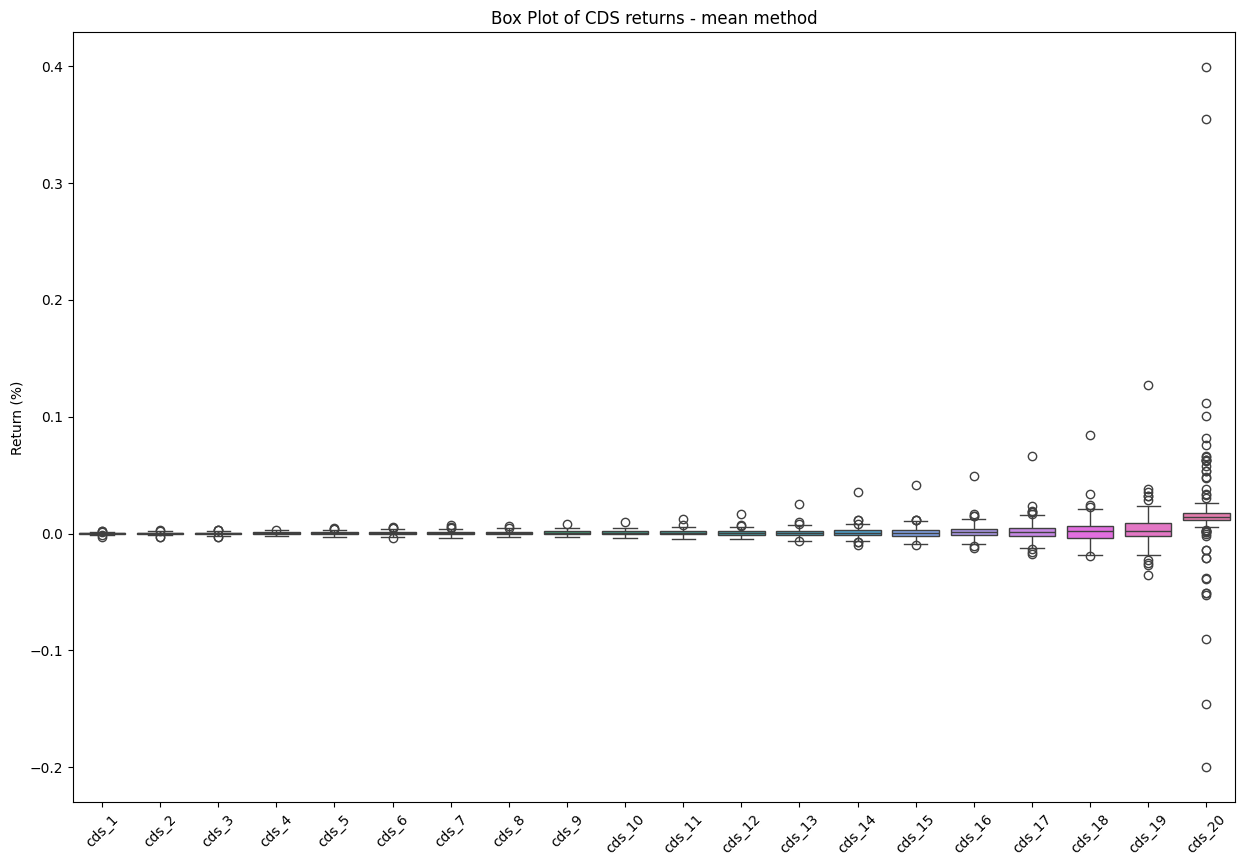

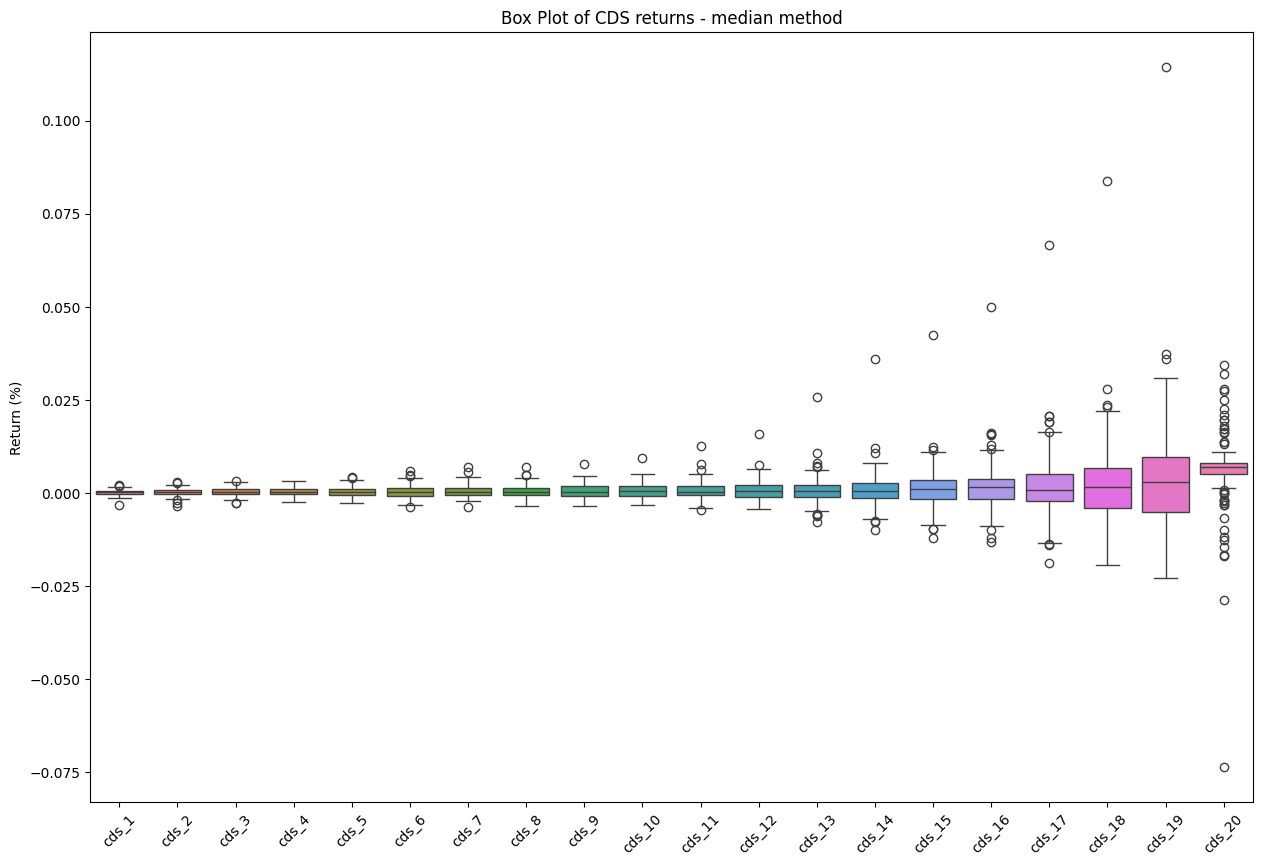

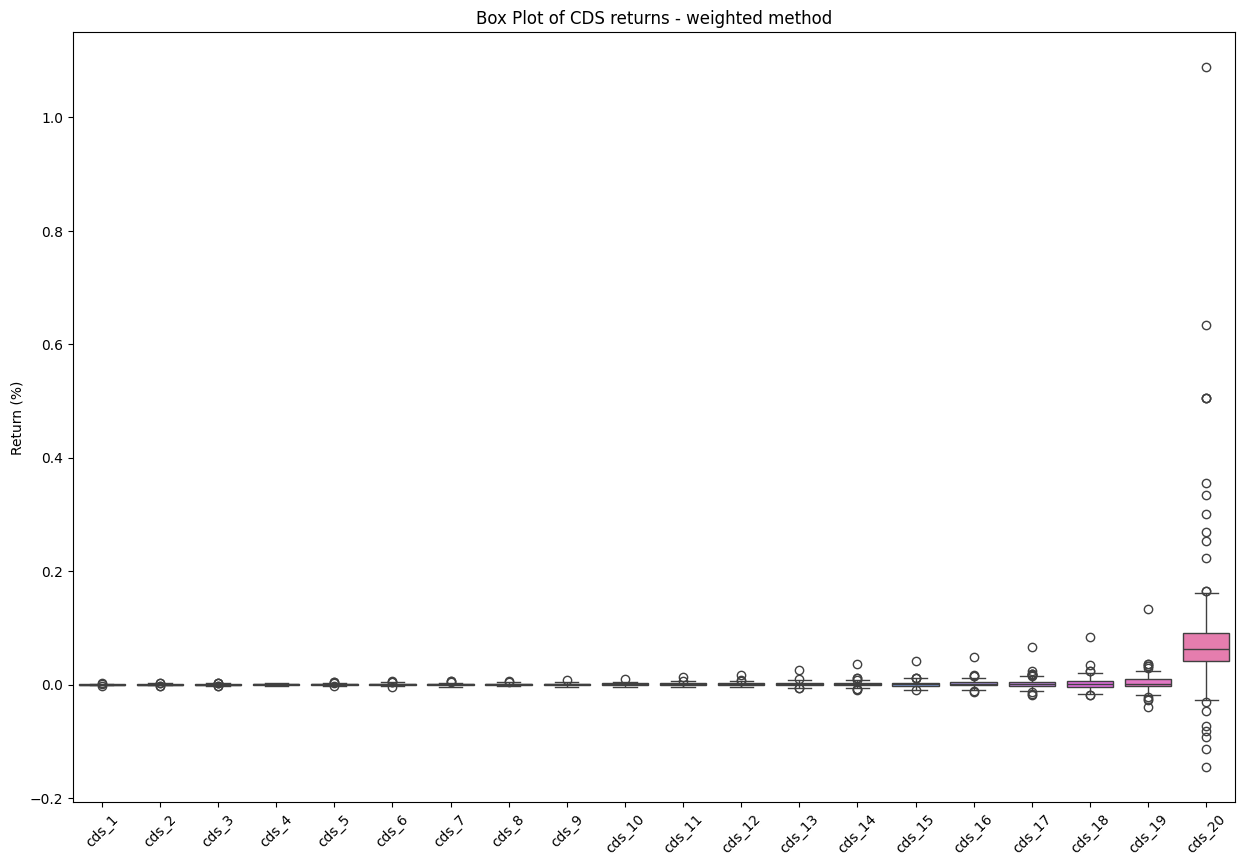

In [16]:
start_date_outsample = '2013-01-02'
end_date_outsample = '2024-01-31'
outsample_mean_plot = plot_cds_returns_mean(start_date_outsample, end_date_outsample,Method='mean')
outsample_median_plot = plot_cds_returns_median(start_date_outsample, end_date_outsample,Method='median')
outsample_weighted_plot = plot_cds_returns_weighted(start_date_outsample, end_date_outsample,Method='weighted')

As one might anticipate, an enhancement in swap spread correlates positively with augmented returns. Nonetheless, this escalation is accompanied by a rise in volatility. The Sharpe ratios exhibit a consistent pattern up to portfolio 19, beyond which there is a notable increment. This trend suggests that, subsequent to portfolio 19, the beneficial influence of returns on the investment's performance surpasses the adverse effects of increased volatility

<img src="../assets/sharpe_ratio.png" alt="Image Description" width="600">